In [0]:
!pip uninstall torch --yes
!pip3 uninstall torch --yes
!pip3 install torch torchvision

In [0]:
import sys, os
try:
  sys.path.remove('/usr/local/lib/python3.6/dist-packages/torch/optim')
except ValueError:
  sys.path.append('/usr/local/lib/python3.6/dist-packages/torch/optim')

In [0]:
#couldn't find a nicer way to put custom optimizers into pytorch module. Spent too long trying. Ugly method ftw

#sys.path.append('/usr/local/lib/python3.6/dist-packages/torch/optim')

import math
import torch
from optimizer import Optimizer


class AMSAggMo(Optimizer):
    """Implements AMSgrad algorithm with Aggregated Momentum.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, beta1=[0, 0.9, 0.99], beta2=0.999, eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        for i, beta in enumerate(beta1):
            if not 0.0 <= beta < 1.0:
                raise ValueError("Invalid beta1 parameter at index {}: {}".format(i, beta))
        if not 0.0 <= beta2 < 1.0:
            raise ValueError("Invalid beta2 parameter: {}".format(beta2))
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(AMSAggMo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AMSAggMo, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
                            
            beta1 = group['beta1']
            beta2 = group['beta2']
            
            max_beta = max(beta1)
            
            #print(avg_mom)
            
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = {}
                    for beta in beta1:
                        state['exp_avg'][beta] =  torch.zeros_like(p.data)
                        
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_sq'] = torch.zeros_like(p.data)
                    
                exp_avg_sq = state['exp_avg_sq']
                max_exp_avg_sq = state['max_exp_avg_sq']
                
                state['step'] += 1

                exp_avg = torch.zeros_like(p.data)
                
                # Decay the first and second moment running average coefficient
                bias_correction1 = 0
                for beta in beta1:
                    buf = state['exp_avg'][beta]   
                    buf.mul_(beta).add_(1 - beta, grad)
                    exp_avg += buf/len(beta1)
                    bias_correction1 += (1 - beta**state['step'])/len(beta1)

                
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                # Maintains the maximum of all 2nd moment running avg. till now
                torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                # Use the max. for normalizing running avg. of gradient
                denom = max_exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                #print('exp_avg')
                #print(exp_avg)
                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss
from optimizer import Optimizer, required


class AggMo(Optimizer):
    r"""Implements Aggregated Momentum Gradient Descent,
    as proposed in `Aggregated Momentum: Stability Through Passive Damping`_.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (list, optional): damping vector (default: [0, 0.9, 0.99])
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    Example:
        >>> optimizer = torch.optim.AggMo(model.parameters(), lr=0.1, momentum=[0,0.9,0.99,0.999])
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    .. _Aggregated Momentum: Stability Through Passive Damping:
        https://arxiv.org/abs/1804.00325
    """

    def __init__(self, params, lr=required, momentum=[0.0, 0.9, 0.99], weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        for i, mom in enumerate(momentum):
            if not 0.0 <= mom:
                raise ValueError("Invalid momentum parameter at index {}: {}".format(i, mom))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay)
        super(AggMo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AggMo, self).__setstate__(state)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            total_mom = float(len(momentum))

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = {}
                    for beta in momentum:
                        param_state['momentum_buffer'][beta] = torch.zeros_like(p.data)
                for beta in momentum:
                    buf = param_state['momentum_buffer'][beta]
                    buf.mul_(beta).add_(d_p)
                    p.data.sub_(group['lr'] / total_mom, buf)
        return loss




In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

In [4]:
#load test and train data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(torch.cuda.is_available())

True


In [0]:
#SGD with Nesterov, Adam, AMSGrad, AMSAggMo and AggMo
net, net1, net2, net3, net4 = Net(), Net(), Net(), Net(), Net()

#setup GPU use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer3 = AMSAggMo(net3.parameters(), lr=0.0005, beta1 = [0,0.9,0.99,0.999])

epochs = 50

In [7]:
net3 = net3.to(device)
amsaggmo_loss = np.zeros([1,epochs])
total = time.time()
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    avg_loss  = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer3.zero_grad()

        # forward + backward + optimize
        outputs = net3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer3.step()

        # print statistics
        running_loss += loss.item()
        avg_loss += loss.item()
        if i % 12000 == 11999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 12000))
            running_loss = 0.0
    amsaggmo_loss[0,epoch] = avg_loss / (i+1)


print('Finished Training AMSAggMo. Time:', time.time()-total,'s')

[1, 12000] loss: 1.530
[2, 12000] loss: 1.240
[3, 12000] loss: 1.125
[4, 12000] loss: 1.047
[5, 12000] loss: 0.983
[6, 12000] loss: 0.929
[7, 12000] loss: 0.879
[8, 12000] loss: 0.838
[9, 12000] loss: 0.802
[10, 12000] loss: 0.763
[11, 12000] loss: 0.730
[12, 12000] loss: 0.701
[13, 12000] loss: 0.673
[14, 12000] loss: 0.648
[15, 12000] loss: 0.620
[16, 12000] loss: 0.600
[17, 12000] loss: 0.575
[18, 12000] loss: 0.552
[19, 12000] loss: 0.531
[20, 12000] loss: 0.511
[21, 12000] loss: 0.494
[22, 12000] loss: 0.476
[23, 12000] loss: 0.458
[24, 12000] loss: 0.441
[25, 12000] loss: 0.428
[26, 12000] loss: 0.409
[27, 12000] loss: 0.396
[28, 12000] loss: 0.382
[29, 12000] loss: 0.373
[30, 12000] loss: 0.358
[31, 12000] loss: 0.345
[32, 12000] loss: 0.336
[33, 12000] loss: 0.323
[34, 12000] loss: 0.311
[35, 12000] loss: 0.306
[36, 12000] loss: 0.293
[37, 12000] loss: 0.284
[38, 12000] loss: 0.273
[39, 12000] loss: 0.265
[40, 12000] loss: 0.256
[41, 12000] loss: 0.250
[42, 12000] loss: 0.236
[

In [10]:


correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net3(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of AMSAggmo on the 10000 test images: %f %%' % (
    100 * correct / float(total)))

Accuracy of AMSAggmo on the 10000 test images: 60.560000 %


In [11]:
for i in range(epochs):
  print(amsaggmo_loss[0, i])

1.5222516883516313
1.2372507465934754
1.1238765206861496
1.045743642448187
0.9820883028125763
0.9299675530123711
0.880023164229393
0.8380502080535889
0.802372867667675
0.7644707567763328
0.731900788024664
0.7015341472518444
0.6738270029139519
0.6488439440453052
0.622546881942749
0.6010810219478607
0.5747778753489255
0.5549031096512079
0.5345450577771663
0.5118102471631766
0.49742496830403804
0.47728183902591464
0.45999387817323206
0.44229846047908067
0.4301663943737745
0.4122201398655772
0.3979848629236221
0.3834538875463605
0.3750728736108542
0.35900225293427707
0.34618623235851526
0.3366216381406784
0.3250194969193637
0.31333180025964974
0.3073205983494222
0.2948481411956251
0.28676798053413627
0.27624339067041875
0.2678960946473852
0.2577073034451902
0.2513411536572874
0.23931002088069916
0.23423332444868983
0.22672434336125852
0.22303630081273615
0.21665291647173465
0.20912109617002309
0.20206958266474306
0.19424583210751414
0.18339696209695192


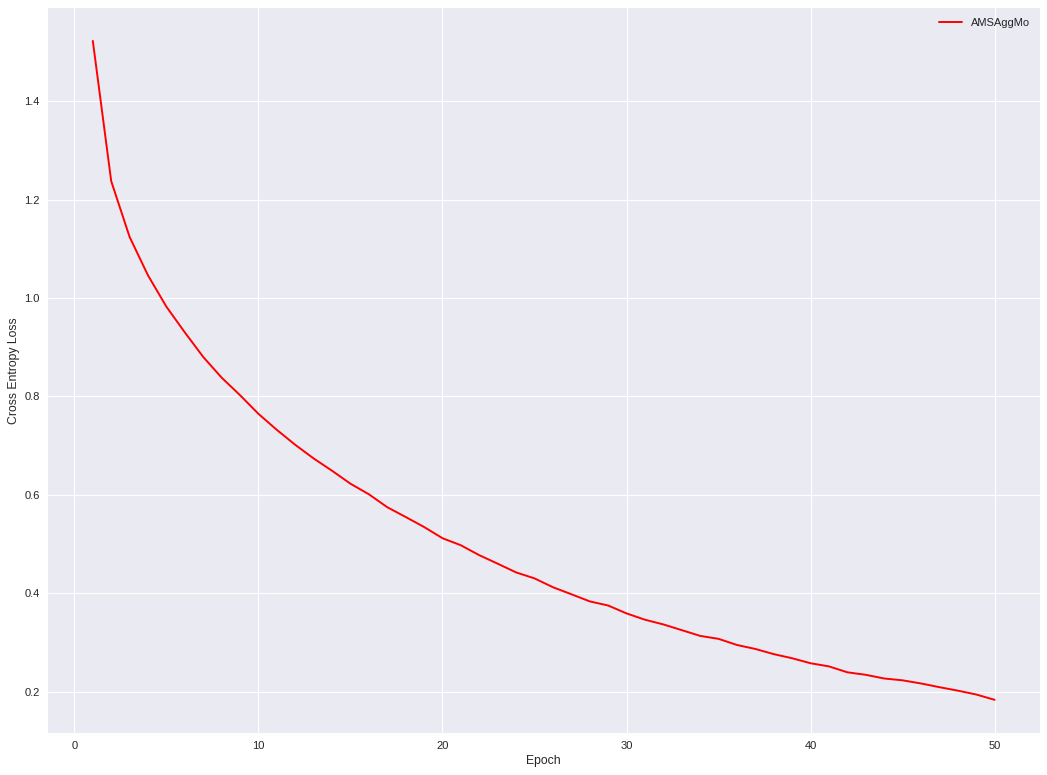

In [12]:
amsaggmo_loss.shape = (epochs,1)


x = np.linspace(1,epochs, num=epochs)
x.shape = (epochs,1)

plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x,amsaggmo_loss,'r',label="AMSAggMo")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()